In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
import os

from natsort import natsorted
from PIL import Image

from torch.autograd import Variable
from IPython.display import clear_output

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
monet_params = {}
monet_params['dnc'] = 3
monet_params['dch'] = 16

monet_params['gnc'] = 3
monet_params['gch'] = 16

picture_params = {}
picture_params['dnc'] = 3
picture_params['dch'] = 16

picture_params['gnc'] = 3
picture_params['gch'] = 16

params = {}
params['epochs'] = 250
params['bs'] = 2

In [4]:
device = 'cuda'

In [5]:
!nvidia-smi

Sat Sep 26 18:35:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   53C    P0    29W / 120W |    758MiB /  3016MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
class DataSetMonet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert('RGB')
        tensor_image = self.transform(image)
        return tensor_image

In [7]:
photo_dataset = DataSetMonet('data/photo_jpg/', transform=torchvision.transforms.ToTensor())
photo_dataloader = DataLoader(photo_dataset, batch_size=params['bs'], shuffle=True, num_workers=4, drop_last=True)

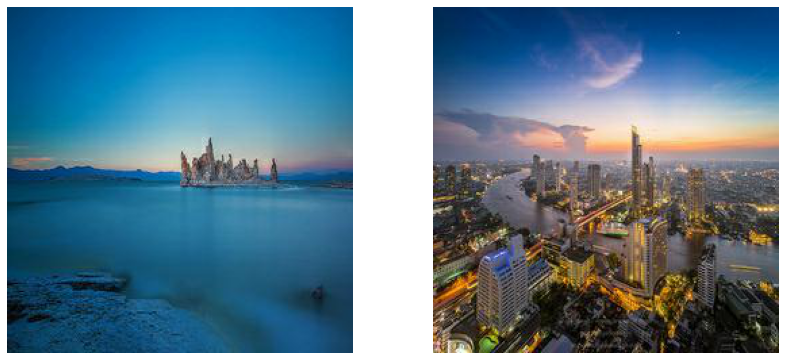

In [8]:
plt.figure(figsize=(14, 14))
data = next(iter(photo_dataloader))
for i in range(params['bs']):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    picture = np.moveaxis(data[i].numpy(), [0, 1, 2], [2, 0, 1])
    plt.imshow(picture)

In [9]:
monet_dataset = DataSetMonet('data/monet_jpg/', transform=torchvision.transforms.ToTensor())
monet_dataloader = DataLoader(monet_dataset, batch_size=params['bs'], shuffle=True, num_workers=4, drop_last=True)

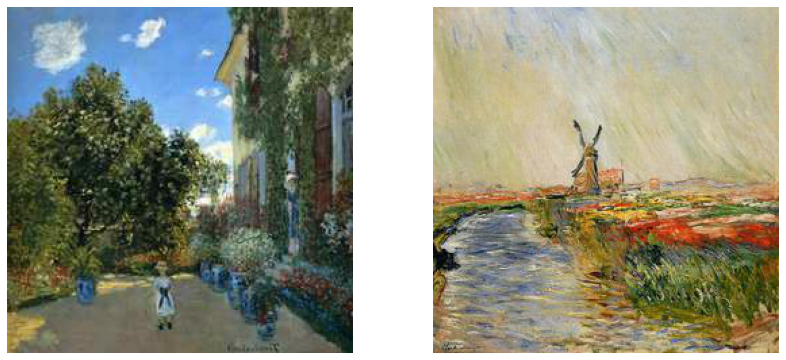

In [10]:
plt.figure(figsize=(14, 14))
data = next(iter(monet_dataloader))
for i in range(params['bs']):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    picture = np.moveaxis(data[i].numpy(), [0, 1, 2], [2, 0, 1])
    plt.imshow(picture)

***Cycle gan***

In [11]:
nc = monet_params['dnc']
ch = monet_params['dch']
class DiscriminatorMonet(nn.Module):
    def __init__(self):
        super(DiscriminatorMonet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(nc, ch, kernel_size=2, stride=2), #128
                                        nn.ReLU(),
                                        nn.Conv2d(ch, ch*2, kernel_size=2, stride=2), #64
                                        nn.ReLU(),
                                        nn.Conv2d(ch*2, ch*4, kernel_size=2, stride=2), #32
                                        nn.ReLU(),
                                        nn.Conv2d(ch*4, 1, kernel_size=2, stride=2), #16
                                        nn.ReLU())
        
        self.linear_layers = nn.Sequential(nn.Linear(16*16, 1),
                                          nn.Sigmoid())
        
    def forward(self, x):
        y = self.conv_layers(x)
        y = y.view(-1, 16*16)
        y = self.linear_layers(y)
        return y

discriminator_monet = DiscriminatorMonet().to(device)
print(discriminator_monet)

DiscriminatorMonet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (7): ReLU()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [12]:
nc = picture_params['dnc']
ch = picture_params['dch']
class DiscriminatorPicture(nn.Module):
    def __init__(self):
        super(DiscriminatorPicture, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(nc, ch, kernel_size=2, stride=2), #128
                                        nn.ReLU(),
                                        nn.Conv2d(ch, ch*2, kernel_size=2, stride=2), #64
                                        nn.ReLU(),
                                        nn.Conv2d(ch*2, ch*4, kernel_size=2, stride=2), #32
                                        nn.ReLU(),
                                        nn.Conv2d(ch*4, 1, kernel_size=2, stride=2), #16
                                        nn.ReLU())
        
        self.linear_layers = nn.Sequential(nn.Linear(16*16, 1),
                                          nn.Sigmoid())
        
    def forward(self, x):
        y = self.conv_layers(x)
        y = y.view(-1, 16*16)
        y = self.linear_layers(y)
        return y

discriminator_picture = DiscriminatorPicture().to(device)
print(discriminator_picture)

DiscriminatorPicture(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (7): ReLU()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [13]:
nc = picture_params['gnc']
ch = picture_params['gch']
class GeneratorPicture(nn.Module):
    def __init__(self):
        super(GeneratorPicture, self).__init__()
        self.double_conv_down1 = nn.Sequential(nn.ConvTranspose2d(in_channels=3, out_channels=ch, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.ConvTranspose2d(in_channels=ch, out_channels=ch, kernel_size=3, padding=1),
                                         nn.ReLU())
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        
        self.double_conv_down2 = nn.Sequential(nn.Conv2d(in_channels=ch, out_channels=ch*2, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=ch*2, out_channels=ch*2, kernel_size=3, padding=1),
                                         nn.ReLU())
        
        self.double_conv_down3 = nn.Sequential(nn.Conv2d(in_channels=ch*2, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=ch*4, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU())
        
        self.double_conv_down4 = nn.Sequential(nn.Conv2d(in_channels=ch*4, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.ConvTranspose2d(in_channels=ch*4, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU())
        
        self.up_conv1 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch*4, out_channels=ch*4, kernel_size=2, stride=2),
                                      nn.ReLU())
        
        self.double_conv_up1 = nn.Sequential(nn.Dropout2d(p=0.5),
                                            nn.Conv2d(in_channels=ch*8, out_channels=ch*2, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch*2, out_channels=ch*2, kernel_size=3, padding=1),
                                            nn.ReLU())
        
        self.up_conv2 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch*2, out_channels=ch*2, kernel_size=2, stride=2),
                                     nn.ReLU())
        
        self.double_conv_up2 = nn.Sequential(nn.Dropout2d(p=0.5),
                                            nn.Conv2d(in_channels=ch*4, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU())
        
        self.up_conv3 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch, out_channels=ch, kernel_size=2, stride=2),
                                     nn.ReLU())
        
        self.double_conv_up3 = nn.Sequential(nn.Dropout2d(p=0.5),
                                            nn.Conv2d(in_channels=ch*2, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch, out_channels=3, kernel_size=3, padding=1),
                                            nn.Tanh())
        
    def forward(self, x):
        x1 = self.double_conv_down1(x)
        x2 = self.double_conv_down2(self.max_pool(x1))
        x3 = self.double_conv_down3(self.max_pool(x2))
        
        x4 = self.double_conv_down4(self.max_pool(x3))

        out = self.up_conv1(x4)
        out = self.double_conv_up1(torch.cat((out, x3), axis=1))
        out = self.up_conv2(out)
        out = self.double_conv_up2(torch.cat((out, x2), axis=1))
        out = self.up_conv3(out)
        out = self.double_conv_up3(torch.cat((out, x1), axis=1))  
        
        return out
generator_picture = GeneratorPicture().to(device)
print(generator_picture)

GeneratorPicture(
  (double_conv_down1): Sequential(
    (0): ConvTranspose2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (double_conv_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (double_conv_down4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [14]:
nc = monet_params['gnc']
ch = monet_params['gch']
class GeneratorMonet(nn.Module):
    def __init__(self):
        super(GeneratorMonet, self).__init__()
        self.double_conv_down1 = nn.Sequential(nn.ConvTranspose2d(in_channels=3, out_channels=ch, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.ConvTranspose2d(in_channels=ch, out_channels=ch, kernel_size=3, padding=1),
                                         nn.ReLU())
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        
        self.double_conv_down2 = nn.Sequential(nn.Conv2d(in_channels=ch, out_channels=ch*2, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=ch*2, out_channels=ch*2, kernel_size=3, padding=1),
                                         nn.ReLU())
        
        self.double_conv_down3 = nn.Sequential(nn.Conv2d(in_channels=ch*2, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=ch*4, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU())
        
        self.double_conv_down4 = nn.Sequential(nn.Conv2d(in_channels=ch*4, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.ConvTranspose2d(in_channels=ch*4, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU())
        
        self.up_conv1 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch*4, out_channels=ch*4, kernel_size=2, stride=2),
                                      nn.ReLU())
        
        self.double_conv_up1 = nn.Sequential(nn.Dropout2d(p=0.5),
                                            nn.Conv2d(in_channels=ch*8, out_channels=ch*2, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch*2, out_channels=ch*2, kernel_size=3, padding=1),
                                            nn.ReLU())
        
        self.up_conv2 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch*2, out_channels=ch*2, kernel_size=2, stride=2),
                                     nn.ReLU())
        
        self.double_conv_up2 = nn.Sequential(nn.Dropout2d(p=0.5),
                                            nn.Conv2d(in_channels=ch*4, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU())
        
        self.up_conv3 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch, out_channels=ch, kernel_size=2, stride=2),
                                     nn.ReLU())
        
        self.double_conv_up3 = nn.Sequential(nn.Dropout2d(p=0.5),
                                            nn.Conv2d(in_channels=ch*2, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch, out_channels=3, kernel_size=3, padding=1),
                                            nn.Tanh())
        
    def forward(self, x):
        x1 = self.double_conv_down1(x)
        x2 = self.double_conv_down2(self.max_pool(x1))
        x3 = self.double_conv_down3(self.max_pool(x2))
        
        x4 = self.double_conv_down4(self.max_pool(x3))

        out = self.up_conv1(x4)
        out = self.double_conv_up1(torch.cat((out, x3), axis=1))
        out = self.up_conv2(out)
        out = self.double_conv_up2(torch.cat((out, x2), axis=1))
        out = self.up_conv3(out)
        out = self.double_conv_up3(torch.cat((out, x1), axis=1))  
        
        return out
generator_monet = GeneratorMonet().to(device)
print(generator_monet)

GeneratorMonet(
  (double_conv_down1): Sequential(
    (0): ConvTranspose2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (double_conv_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (double_conv_down4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (

In [15]:
optimizer_monet_g = torch.optim.Adam(params=generator_monet.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_monet_d = torch.optim.Adam(params=discriminator_monet.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_picture_g = torch.optim.Adam(params=generator_picture.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_picture_d = torch.optim.Adam(params=discriminator_picture.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [16]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = torch.mean(torch.abs(real_image - cycled_image))
    return loss1
def calc_identity_loss(real_image, cycled_image):
    loss1 = torch.mean(torch.abs(real_image - cycled_image))
    return loss1
def calc_discriminator_loss(real, generated):
    real_loss = F.binary_cross_entropy(real, torch.ones_like(real))
    generated_loss = F.binary_cross_entropy(generated, torch.zeros_like(generated))
    total_disc_loss = real_loss + generated_loss
    return  total_disc_loss
def calc_generator_loss(generated):
    return F.binary_cross_entropy(generated, torch.ones_like(generated))

Epoch:  29  /  250


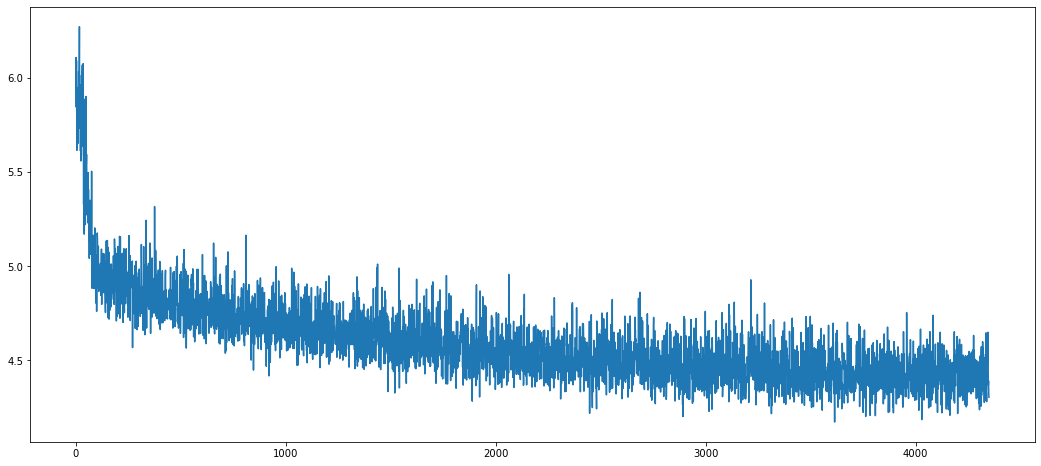

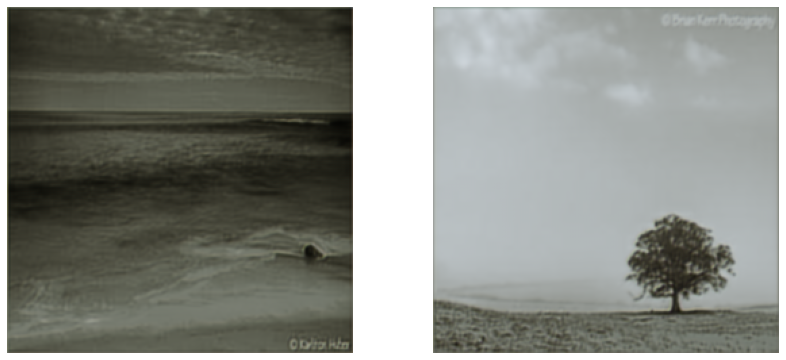

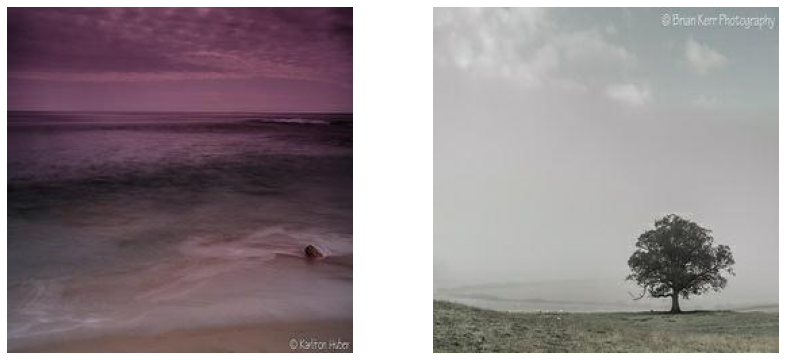

KeyboardInterrupt: 

In [17]:
losses = []
for epoch in range(1, params['epochs'] + 1):
    for i, data in enumerate(zip(monet_dataloader, photo_dataloader)):
        real_monet, real_photo = data[0].to(device), data[1].to(device)
        real_monet = 2*real_monet - 1
        real_photo = 2*real_photo - 1
        generator_monet.zero_grad()
        generator_picture.zero_grad()
        discriminator_monet.zero_grad()
        discriminator_picture.zero_grad()
        
        fake_monet = generator_monet(real_photo)
        cycled_photo = generator_picture(fake_monet)
        
        fake_photo = generator_picture(real_monet)
        cycled_monet = generator_monet(fake_photo)
        
        same_monet = generator_monet(real_monet)
        same_photo = generator_picture(real_photo)
        
        disc_real_monet = discriminator_monet(real_monet)
        disc_fake_monet = discriminator_monet(fake_monet)
        
        disc_real_photo = discriminator_picture(real_photo)
        disc_fake_photo = discriminator_picture(fake_photo)
        
        
        identity_loss = calc_identity_loss(same_monet, real_monet) + calc_identity_loss(same_photo, real_photo)
        
        cycle_loss = calc_cycle_loss(real_monet, cycled_monet) + calc_cycle_loss(real_photo, cycled_photo)
        
        generator_loss = calc_generator_loss(disc_fake_monet) + calc_generator_loss(disc_fake_photo)
        
        discriminator_loss = calc_discriminator_loss(disc_real_monet, disc_fake_monet) + calc_discriminator_loss(disc_real_photo, disc_fake_photo)
        
        loss = identity_loss + cycle_loss + generator_loss + discriminator_loss
        loss.backward()
        losses.append(loss.item())
        
        optimizer_monet_d.step()
        optimizer_monet_g.step()
        optimizer_picture_d.step()
        optimizer_picture_g.step()
    
    clear_output('True')
    print('Epoch: ', epoch, ' / ', params['epochs'])
    plt.figure(figsize=(18, 8))
    plt.plot(losses)
    plt.show()
    plt.figure(figsize=(14, 14))
    data = fake_monet.detach().to('cpu')
    data = (data + 1)/2
    for i in range(2):
        plt.subplot(2, 2, i + 1)
        plt.axis('off')
        picture = np.moveaxis(data[i].numpy(), [0, 1, 2], [2, 0, 1])
        plt.imshow(picture)
    plt.show()
    plt.figure(figsize=(14, 14))
    data = real_photo.detach().to('cpu')
    data = (data + 1)/2
    for i in range(2):
        plt.subplot(2, 2, i + 1)
        plt.axis('off')
        picture = np.moveaxis(data[i].numpy(), [0, 1, 2], [2, 0, 1])
        plt.imshow(picture)
    plt.show()

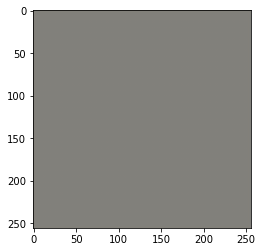

In [22]:
plt.imshow(np.moveaxis(cycled_photo[0].cpu().detach().numpy(), [0, 1, 2], [2, 0, 1]))

In [36]:
cycled_photo[0] - real_photo[0]

tensor([[[ 3.3309e-01,  3.8179e-01,  4.3071e-01,  ...,  3.0542e-01,
           3.5949e-01,  4.0494e-01],
         [ 2.5443e-01,  2.1659e-01,  2.7600e-01,  ...,  1.9857e-01,
           2.6891e-01,  3.2690e-01],
         [ 2.0293e-01,  1.6950e-01,  2.3884e-01,  ...,  1.9857e-01,
           2.4485e-01,  2.8508e-01],
         ...,
         [ 3.2812e-01,  1.5606e-01,  1.3313e-01,  ..., -1.9103e-02,
           1.8097e-02,  9.4118e-02],
         [ 3.9211e-01,  2.8662e-01,  2.7422e-01,  ...,  1.0105e-01,
           7.1022e-02,  1.2978e-01],
         [ 4.1044e-01,  3.1990e-01,  2.7925e-01,  ...,  1.3980e-01,
           7.8075e-02,  1.6165e-01]],

        [[ 2.3078e-01,  2.7627e-01,  2.8380e-01,  ...,  1.4275e-01,
           1.9022e-01,  2.7061e-01],
         [ 1.4794e-01,  1.0882e-01,  1.4397e-01,  ...,  4.4659e-02,
           1.0586e-01,  1.9558e-01],
         [ 8.4454e-02,  5.4286e-02,  8.7189e-02,  ...,  2.1658e-02,
           5.6079e-02,  1.6545e-01],
         ...,
         [ 2.3587e-01,  1

In [34]:
torch.mean(torch.abs(cycled_photo[0] - real_photo[0]))

tensor(0.0979, device='cuda:0', grad_fn=<MeanBackward0>)

In [18]:
torch.mean(f

tensor([[[0.4532, 0.4146, 0.4011,  ..., 0.4143, 0.4247, 0.4568],
         [0.4020, 0.3479, 0.3268,  ..., 0.3515, 0.3694, 0.4303],
         [0.3857, 0.3310, 0.3099,  ..., 0.3358, 0.3576, 0.4259],
         ...,
         [0.3590, 0.2951, 0.2677,  ..., 0.3224, 0.3478, 0.4230],
         [0.3740, 0.3218, 0.2995,  ..., 0.3486, 0.3716, 0.4368],
         [0.4237, 0.3990, 0.3890,  ..., 0.4194, 0.4353, 0.4760]],

        [[0.4461, 0.4202, 0.4116,  ..., 0.4232, 0.4343, 0.4581],
         [0.3991, 0.3509, 0.3300,  ..., 0.3535, 0.3750, 0.4273],
         [0.3894, 0.3332, 0.3104,  ..., 0.3371, 0.3589, 0.4184],
         ...,
         [0.3657, 0.2941, 0.2674,  ..., 0.3162, 0.3449, 0.4101],
         [0.3763, 0.3134, 0.2874,  ..., 0.3352, 0.3582, 0.4190],
         [0.4166, 0.3754, 0.3589,  ..., 0.3896, 0.4052, 0.4460]],

        [[0.4185, 0.3826, 0.3702,  ..., 0.3899, 0.4033, 0.4477],
         [0.3701, 0.2994, 0.2770,  ..., 0.3041, 0.3234, 0.3909],
         [0.3538, 0.2739, 0.2473,  ..., 0.2763, 0.2969, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


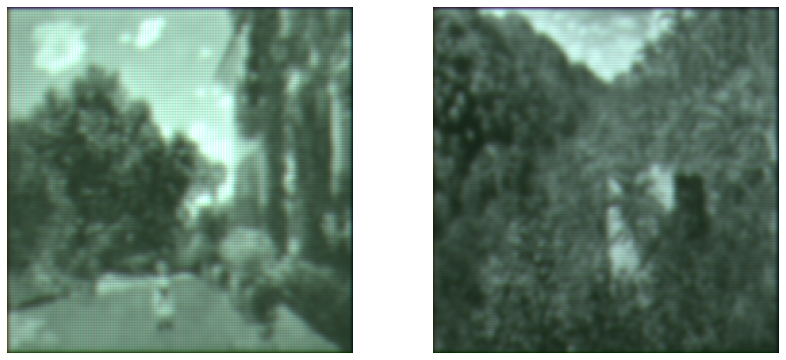

In [26]:
plt.figure(figsize=(14, 14))
data = same_monet.detach().to('cpu')
for i in range(2):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    picture = np.moveaxis(data[i].numpy(), [0, 1, 2], [2, 0, 1])
    plt.imshow(picture)

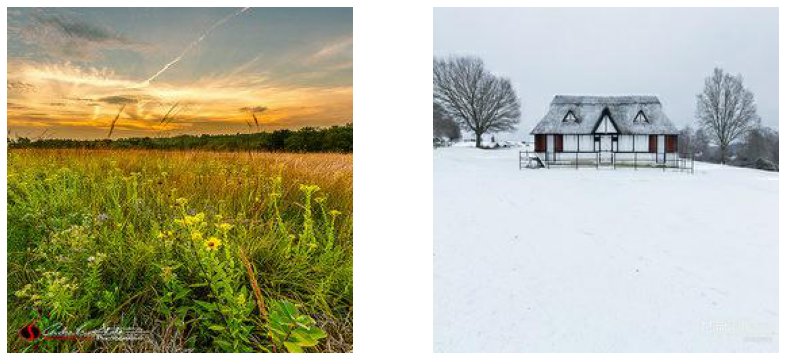

In [23]:
plt.figure(figsize=(14, 14))
data = real_photo.detach().to('cpu')
for i in range(2):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    picture = np.moveaxis(data[i].numpy(), [0, 1, 2], [2, 0, 1])
    plt.imshow(picture)